[d=1, M=200] gamma=2.828, train_loss~1.501e-09, MSE=1.943e-15
[d=2, M=200] gamma=2.277, train_loss~2.927e-04, MSE=2.031e-07
[d=3, M=200] gamma=2.173, train_loss~4.852e+01, MSE=4.552e-02
[d=4, M=200] gamma=2.265, train_loss~8.146e+02, MSE=4.057e-01
[d=5, M=200] gamma=4.420, train_loss~1.055e+03, MSE=2.587e-01
[d=6, M=200] gamma=5.823, train_loss~8.429e+02, MSE=5.599e-02
[d=7, M=200] gamma=59.012, train_loss~5.919e+02, MSE=7.458e-03
[d=8, M=200] gamma=5.903, train_loss~3.937e+02, MSE=5.987e-03
[d=9, M=200] gamma=100.000, train_loss~2.422e+02, MSE=1.920e-03
[d=10, M=200] gamma=3.090, train_loss~1.444e+02, MSE=4.233e-03
[d=1, M=400] gamma=5.695, train_loss~1.025e-09, MSE=2.130e-16
[d=2, M=400] gamma=3.194, train_loss~6.644e-06, MSE=4.895e-09
[d=3, M=400] gamma=2.324, train_loss~6.266e+00, MSE=1.073e-02
[d=4, M=400] gamma=2.121, train_loss~3.265e+02, MSE=2.028e-01
[d=5, M=400] gamma=3.992, train_loss~8.822e+02, MSE=4.234e-01
[d=6, M=400] gamma=4.280, train_loss~8.145e+02, MSE=1.374e-01
[d=7

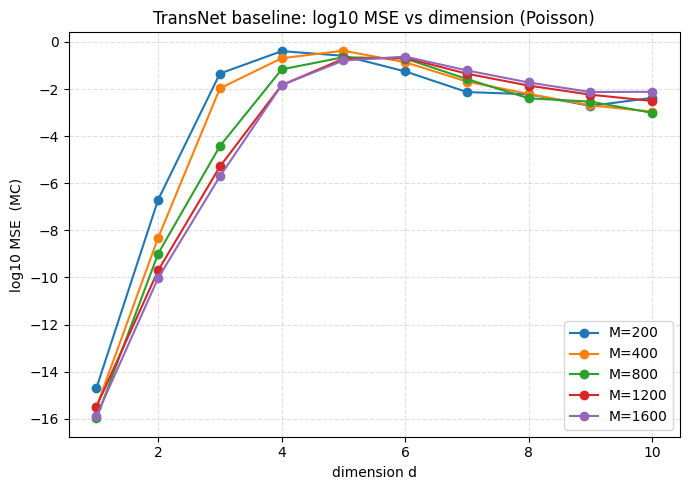


=== Table: MSE by d & M ===
d= 1 | M=200: MSE=1.943e-15 | M=400: MSE=2.130e-16 | M=800: MSE=4.561e-18 | M=1200: MSE=2.269e-16 | M=1600: MSE=3.191e-17
d= 2 | M=200: MSE=2.031e-07 | M=400: MSE=4.895e-09 | M=800: MSE=1.039e-09 | M=1200: MSE=2.002e-10 | M=1600: MSE=9.559e-11
d= 3 | M=200: MSE=4.552e-02 | M=400: MSE=1.073e-02 | M=800: MSE=3.795e-05 | M=1200: MSE=5.146e-06 | M=1600: MSE=1.968e-06
d= 4 | M=200: MSE=4.057e-01 | M=400: MSE=2.028e-01 | M=800: MSE=6.836e-02 | M=1200: MSE=1.466e-02 | M=1600: MSE=1.463e-02
d= 5 | M=200: MSE=2.587e-01 | M=400: MSE=4.234e-01 | M=800: MSE=2.239e-01 | M=1200: MSE=1.926e-01 | M=1600: MSE=1.627e-01
d= 6 | M=200: MSE=5.599e-02 | M=400: MSE=1.374e-01 | M=800: MSE=1.977e-01 | M=1200: MSE=2.093e-01 | M=1600: MSE=2.380e-01
d= 7 | M=200: MSE=7.458e-03 | M=400: MSE=2.073e-02 | M=800: MSE=2.652e-02 | M=1200: MSE=4.478e-02 | M=1600: MSE=6.169e-02
d= 8 | M=200: MSE=5.987e-03 | M=400: MSE=6.174e-03 | M=800: MSE=4.026e-03 | M=1200: MSE=1.398e-02 | M=1600: MSE=1.896

In [10]:
# ============================================
# TransNet baseline: MSE vs dimension (d-D Poisson)
# Domain: [0,1]^d,    u*(x) = ∏_{i=1}^d sin(kappa*pi*x_i)
# PDE: -Δu = f = (kappa*pi)^2 * d * u
# Dirichlet BC: u|∂Ω = 0
# ============================================

import numpy as np
import math, time
import matplotlib.pyplot as plt

# ---------- config ----------
kappa = 2                # frequency in exact solution
pi = math.pi
R = 1.5               # shift range for random features r ~ U[-R, R]
gamma_search = (1e-2, 1e2)   # linear-domain golden search range
w_pde, w_bc = 1.0, 5.0        # loss weights (bc稍强一些更稳)
reg = 1e-8              # ridge regularization (col-normalized)
n_interior = 20000       # MC interior sample size for training
n_boundary = 20000       # MC boundary sample size for training
n_test = 30000           # MC test points for MSE
seeds = dict(basis=2025, data=7)

dims_list = [1,2,3,4,5,6,7,8,9,10]     # try 1..10
M_list = [200,400,800,1200,1600]               # neurons

# ---------- exact solution & rhs ----------
def u_exact(x):  # x: (N,d)
    return np.prod(np.sin(kappa*pi*x), axis=1)

def f_rhs(x):    # f = (kappa*pi)^2 * d * u
    d = x.shape[1]
    return (kappa*pi)**2 * d * u_exact(x)

# ---------- sampling ----------
def sample_interior(d, N, rng):
    # Uniform in (0,1)^d
    return rng.rand(N, d)

def sample_boundary(d, N, rng):
    # Sample random faces uniformly: choose a coordinate to clamp to 0 or 1
    X = rng.rand(N, d)
    faces = rng.randint(0, d, size=N)
    sides = rng.randint(0, 2, size=N)
    for i in range(N):
        X[i, faces[i]] = float(sides[i])  # 0 or 1
    return X


def sample_test(d, N, rng):
    return rng.rand(N, d)

# ---------- TransNet feature ----------
def sigma(s): return np.tanh(s)
def sigma_dd(s):
    t = np.tanh(s)
    return -2.0 * t * (1.0 - t*t)

def sample_a_r(M, d, R, rng):
    A = rng.randn(M, d)
    A /= np.linalg.norm(A, axis=1, keepdims=True) + 1e-12
    r = rng.uniform(-R, R, size=M)
    return A, r

def build_blocks_poisson(X_int, X_bd, A, r, gamma, xi_c=None):
    # X_int: interior points, X_bd: boundary points
    if xi_c is None:
        xi_c = np.full((X_int.shape[1],), 0.5, dtype=np.float64)
    # center
    Xc_int = X_int - xi_c[None,:]
    Xc_bd  = X_bd  - xi_c[None,:]

    # scores
    S_int = gamma * (Xc_int @ A.T + r[None,:])   # (Ni,M)
    S_bd  = gamma * (Xc_bd  @ A.T + r[None,:])   # (Nb,M)

    # Laplacian of feature: -Δψ = -sum_i ψ_xi_xi = -σ''(S)*γ^2 * ||a||^2 (||a||=1)
    # Here ||a||^2 = 1 by construction
    L_int = - sigma_dd(S_int) * (gamma**2)       # (Ni,M)

    # boundary value block
    Psi_bd = sigma(S_bd)                         # (Nb,M)

    return L_int, Psi_bd

def solve_alpha_colnorm(A_pde, A_bc, rhs_pde, rhs_bc, w_pde=1.0, w_bc=5.0, reg=1e-3):
    # stack with weights
    A_big = np.vstack([w_pde*A_pde, w_bc*A_bc])
    b_big = np.concatenate([w_pde*rhs_pde, w_bc*rhs_bc])

    # column normalization
    col_norm = np.linalg.norm(A_big, axis=0) + 1e-12
    A_norm = A_big / col_norm[None,:]

    # ridge
    AtA = A_norm.T @ A_norm + reg*np.eye(A_norm.shape[1])
    Atb = A_norm.T @ b_big
    beta = np.linalg.solve(AtA, Atb)
    alpha = beta / col_norm
    return alpha

def u_base_numpy(X, A, r, gamma, alpha, xi_c=None):
    if xi_c is None:
        xi_c = np.full((X.shape[1],), 0.5, dtype=np.float64)
    Xc = X - xi_c[None,:]
    S  = gamma * (Xc @ A.T + r[None,:])
    return sigma(S) @ alpha

# ---------- golden section (linear scale) ----------
def golden_search(func, a, b, tol=1e-3, max_iters=60):
    phi = (1 + 5**0.5)/2.0
    invphi = 1.0/phi
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = func(c)
    fd = func(d)
    it = 0
    while (b-a) > tol and it < max_iters:
        it += 1
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a)
            fc = func(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a)
            fd = func(d)
    return (c, fc) if fc < fd else (d, fd)

# ---------- runner for one (d, M) ----------     #这里是对每一组(d,M)进行的实验
def run_once(d, M, seeds, verbose=False):
    rng_basis = np.random.RandomState(seeds['basis'] + d*1000 + M)  #不同的d和M会用不同的随机数种子
    rng_data  = np.random.RandomState(seeds['data']  + d*1000 + M)  

    # data
    X_int = sample_interior(d, n_interior, rng_data)
    X_bd  = sample_boundary(d, n_boundary, rng_data)
    rhs_pde = f_rhs(X_int)    # -Δu = f
    rhs_bc  = np.zeros(X_bd.shape[0])   # u|∂Ω = 0

    # basis
    A, r = sample_a_r(M, d, R, rng_basis)

    # gamma objective
    def eta_gamma(gamma):
        L_int, Psi_bd = build_blocks_poisson(X_int, X_bd, A, r, gamma)
        alpha = solve_alpha_colnorm(L_int, Psi_bd, rhs_pde, rhs_bc,
                                    w_pde=w_pde, w_bc=w_bc, reg=reg)
        e_pde = L_int @ alpha - rhs_pde
        e_bc  = Psi_bd @ alpha - rhs_bc
        # training loss proxy
        return np.mean(e_pde**2) + w_bc/w_pde * np.mean(e_bc**2)

    # search gamma
    g_lo, g_hi = gamma_search
    gamma_opt, loss = golden_search(eta_gamma, g_lo, g_hi, tol=1e-3, max_iters=60)

    # final alpha
    L_int, Psi_bd = build_blocks_poisson(X_int, X_bd, A, r, gamma_opt)
    alpha_opt = solve_alpha_colnorm(L_int, Psi_bd, rhs_pde, rhs_bc,
                                    w_pde=w_pde, w_bc=w_bc, reg=reg)

    # test MSE (Monte Carlo)
    X_te = sample_test(d, n_test, rng_data)
    u_pred = u_base_numpy(X_te, A, r, gamma_opt, alpha_opt)
    mse = np.mean((u_pred - u_exact(X_te))**2)

    if verbose:
        print(f"[d={d}, M={M}] gamma={gamma_opt:.3f}, train_loss~{loss:.3e}, MSE={mse:.3e}")
    return gamma_opt, mse

# ---------- sweep ----------
results = {}   # results[(d, M)] = (gamma_opt, mse)
t0 = time.time()
for M in M_list:
    for d in dims_list:
        gamma_opt, mse = run_once(d, M, seeds, verbose=True)
        results[(d, M)] = (gamma_opt, mse)
t1 = time.time()
print(f"\nTotal time: {(t1-t0):.2f}s")

# ---------- plotting ----------
plt.figure(figsize=(7.0,5.0))
for M in M_list:
    xs = []; ys = []
    for d in dims_list:
        xs.append(d)
        ys.append(results[(d,M)][1] + 1e-16)
    plt.plot(xs, np.log10(ys), marker='o', label=f"M={M}")
plt.xlabel("dimension d")
plt.ylabel("log10 MSE  (MC)")
plt.title("TransNet baseline: log10 MSE vs dimension (Poisson)")
plt.grid(True, ls='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# (可选) 打印表
print("\n=== Table: MSE by d & M ===")
for d in dims_list:
    row = [f"d={d:2d}"]
    for M in M_list:
        row.append(f"M={M}: MSE={results[(d,M)][1]:.3e}")
    print(" | ".join(row))



===== M = 200 =====

[Dimension d=1]
gamma_opt=2.606, mse_int=1.01e-13, mse_bd=1.64e-24
[Baseline] MSE = 1.206e-18
Epoch    0: total=1.068e+00, pde=9.270e-03, bd=1.058e-01
Epoch  400: total=4.326e-05, pde=4.326e-05, bd=2.840e-10
Epoch  800: total=2.914e-05, pde=2.912e-05, bd=1.611e-09
Epoch 1200: total=1.718e-05, pde=1.717e-05, bd=9.564e-10
Epoch 1600: total=8.468e-06, pde=8.464e-06, bd=3.897e-10
[Hybrid] MSE = 2.695e-09

[Dimension d=2]
gamma_opt=1.916, mse_int=9.13e-08, mse_bd=1.02e-08
[Baseline] MSE = 1.260e-09
Epoch    0: total=4.127e-01, pde=1.247e-02, bd=4.002e-02
Epoch  400: total=6.803e-04, pde=5.462e-04, bd=1.341e-05
Epoch  800: total=1.097e-04, pde=3.689e-05, bd=7.282e-06
Epoch 1200: total=4.483e-05, pde=1.106e-05, bd=3.377e-06
Epoch 1600: total=2.634e-05, pde=7.264e-06, bd=1.908e-06
[Hybrid] MSE = 3.832e-07

[Dimension d=3]
gamma_opt=1.806, mse_int=1.17e+01, mse_bd=1.18e+00
[Baseline] MSE = 3.230e-01
Epoch    0: total=1.280e+01, pde=1.169e+01, bd=1.113e-01
Epoch  400: total

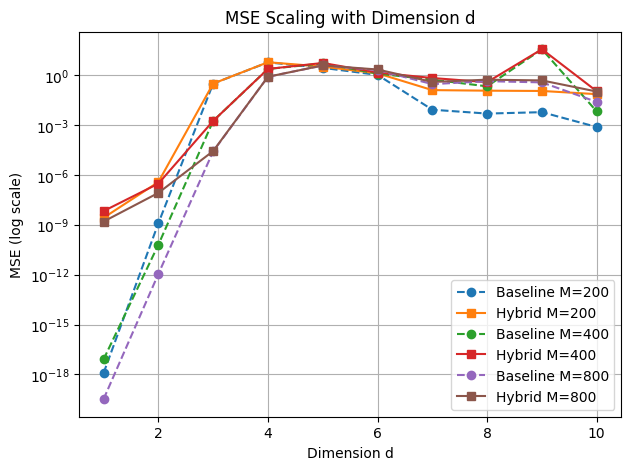

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import math, time, csv
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pi = math.pi

# ---------- Exact solution ----------
def u_exact_np(X):
    return np.prod(np.sin(2*pi*X), axis=1)

def f_forcing_np(X):
    d = X.shape[1]
    return (2*pi)**2 * d * np.prod(np.sin(2*pi*X), axis=1)

def u_exact_torch(x):
    return torch.prod(torch.sin(2*pi*x), dim=1)

def f_forcing_torch(x):
    d = x.shape[1]
    return (2*pi)**2 * d * torch.prod(torch.sin(2*pi*x), dim=1)

# ---------- Sampling ----------
def sample_interior(d, n):
    return np.random.rand(n, d)

def sample_boundary(d, n_per_side):
    """2d faces per dimension"""
    pts = []
    for i in range(d):
        for side in [0.0, 1.0]:
            X = np.random.rand(n_per_side, d)
            X[:, i] = side
            pts.append(X)
    return np.vstack(pts)

# ---------- TransNet helpers ----------
def sigma(s): return np.tanh(s)
def sigma_dd(s):
    t = np.tanh(s)
    sech2 = 1 - t*t
    return -2.0 * t * sech2

def sample_a_r(M, d, R=1.5, seed=1234):
    rng = np.random.RandomState(seed)
    A = rng.randn(M, d)
    A /= np.linalg.norm(A, axis=1, keepdims=True)
    r = rng.rand(M)*R
    return A, r

def build_matrices(X_int, X_bd, A, rvec, gamma, xc):
    X_int_c = X_int - xc
    X_bd_c = X_bd - xc
    s_int = X_int_c @ A.T + rvec.reshape(1,-1)
    s_bd = X_bd_c @ A.T + rvec.reshape(1,-1)
    S_int = gamma * s_int
    S_bd = gamma * s_bd
    Psi_int = sigma(S_int)
    Psi_bd = sigma(S_bd)
    Psi_dd_int = (gamma**2) * sigma_dd(S_int)
    F_int = -Psi_dd_int
    return F_int, Psi_bd

def solve_alpha_ls(F_int, Psi_bd, f_int, g_bd, w_L=1.0, w_B=1.0, reg=1e-8):
    A_big = np.vstack([math.sqrt(w_L)*F_int, math.sqrt(w_B)*Psi_bd])
    rhs = np.concatenate([math.sqrt(w_L)*f_int, math.sqrt(w_B)*g_bd])
    AtA = A_big.T @ A_big + reg*np.eye(A_big.shape[1])
    Atb = A_big.T @ rhs
    return np.linalg.solve(AtA, Atb)

def u_base_numpy(X, A, rvec, gamma, alpha, xc):
    s = (X - xc) @ A.T + rvec.reshape(1,-1)
    return sigma(gamma*s) @ alpha

# ---------- Golden-section search ----------
def eta_of_gamma(gamma, X_int, X_bd, f_int, g_bd, A, rvec, xc):
    F_int, Psi_bd = build_matrices(X_int, X_bd, A, rvec, gamma, xc)
    alpha = solve_alpha_ls(F_int, Psi_bd, f_int, g_bd)
    resid_int = F_int@alpha - f_int
    resid_bd = Psi_bd@alpha - g_bd
    mse_int = np.mean(resid_int**2)
    mse_bd = np.mean(resid_bd**2)
    return mse_int + mse_bd, mse_int, mse_bd

def golden_search(func, a, b, tol=1e-5, max_iters=60):
    phi = (1 + 5**0.5)/2
    invphi = 1/phi
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = func(c)
    fd = func(d)
    for _ in range(max_iters):
        if (b - a) < tol: break
        if fc[0] < fd[0]:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a)
            fc = func(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a)
            fd = func(d)
    return (c, fc) if fc[0] < fd[0] else (d, fd)

# ---------- Laplacian ----------
def laplacian(u, x):
    grad = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    lap = 0
    for i in range(x.shape[1]):
        grad2 = autograd.grad(grad[:, i], x, grad_outputs=torch.ones_like(grad[:, i]), create_graph=True)[0][:, i]
        lap += grad2
    return lap

# ---------- Residual MLP ----------
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, depth=1):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(-1)

# ---------- Main experiment ----------
dims_list = list(range(1, 11))
M_list = [200, 400, 800]
n_int, n_bd = 2000, 400
results = []

for M in M_list:
    print(f"\n===== M = {M} =====")
    for d in dims_list:
        print(f"\n[Dimension d={d}]")
        xc = np.full((d,), 0.5)
        X_int = sample_interior(d, n_int)
        X_bd = sample_boundary(d, n_bd)
        f_int = f_forcing_np(X_int)
        g_bd = np.zeros(X_bd.shape[0])

        A, rvec = sample_a_r(M, d, seed=2025)
        func = lambda g: eta_of_gamma(g, X_int, X_bd, f_int, g_bd, A, rvec, xc)
        gamma_opt, best = golden_search(func, 1e-2, 80.0)
        eta, mse_int, mse_bd = best
        print(f"gamma_opt={gamma_opt:.3f}, mse_int={mse_int:.2e}, mse_bd={mse_bd:.2e}")

        F_int, Psi_bd = build_matrices(X_int, X_bd, A, rvec, gamma_opt, xc)
        alpha_opt = solve_alpha_ls(F_int, Psi_bd, f_int, g_bd)
        X_test = np.random.rand(1000, d)
        u_base = u_base_numpy(X_test, A, rvec, gamma_opt, alpha_opt, xc)
        mse_base = np.mean((u_base - u_exact_np(X_test))**2)
        print(f"[Baseline] MSE = {mse_base:.3e}")

        # ---- Hybrid residual ----
        X_int_t = torch.tensor(X_int, device=device)
        X_bd_t = torch.tensor(X_bd, device=device)
        A_t = torch.tensor(A, device=device)
        r_t = torch.tensor(rvec, device=device)
        alpha_t = torch.tensor(alpha_opt, device=device)
        xc_t = torch.tensor(xc, device=device)

        def u_base_torch(x):
            s = (x - xc_t) @ A_t.T + r_t
            return torch.tanh(gamma_opt * s) @ alpha_t

        model = MLP(in_dim=d, hidden=64, depth=1).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        lambda_bd = 10.0
        epochs = 2000

        for ep in range(epochs):
            opt.zero_grad()
            x = X_int_t.clone().detach().requires_grad_(True)
            v = model(x)
            lap_v = laplacian(v, x)
            u_b = u_base_torch(x)
            lap_ub = laplacian(u_b, x)
            r_pde = f_forcing_torch(x) + lap_ub
            loss_pde = torch.mean((-lap_v - r_pde)**2)

            v_bd = model(X_bd_t)
            loss_bd = torch.mean(v_bd**2)

            loss = loss_pde + lambda_bd * loss_bd
            loss.backward()
            opt.step()
            if ep % 400 == 0:
                print(f"Epoch {ep:4d}: total={loss.item():.3e}, pde={loss_pde.item():.3e}, bd={loss_bd.item():.3e}")

        X_test_t = torch.tensor(X_test, device=device)
        u_pred = u_base_torch(X_test_t) + model(X_test_t)
        mse_hybrid = torch.mean((u_pred - u_exact_torch(X_test_t))**2).item()
        print(f"[Hybrid] MSE = {mse_hybrid:.3e}")

        results.append([d, M, gamma_opt, mse_base, mse_hybrid])

# ---------- Save results ----------
csv_name = "transnet_hybrid_dim_study.csv"
with open(csv_name, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["d", "M", "gamma_opt", "MSE_base", "MSE_hybrid"])
    writer.writerows(results)
print(f"\nResults saved to {csv_name}")

# ---------- Plot ----------
results = np.array(results)
plt.figure(figsize=(7,5))
for M in M_list:
    mask = results[:,1]==M
    plt.semilogy(results[mask,0], results[mask,3], 'o--', label=f'Baseline M={M}')
    plt.semilogy(results[mask,0], results[mask,4], 's-', label=f'Hybrid M={M}')
plt.xlabel('Dimension d')
plt.ylabel('MSE (log scale)')
plt.title('MSE Scaling with Dimension d')
plt.legend()
plt.grid(True)
plt.show()
